# Tutorial 1: Weighted Hazard Scenarios for Risk Assessment

In this tutorial, we cover the following topics:

* Get started with `pyRiskTable` package
* Obtain weighted hazard scenarios and estimate risk
* Use custom hazard and fragility functions

## Get started with `pyRiskTable` package

The dependent packages for `pyRiskTable` are stored in `requirements.txt` file. To install these packages, one can run the following command in terminal:
```console
pip install -r requirements.txt
```
Once the packages are installed, we can first import some common packages used by the following code cells.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Once the packages are installed, we need to define the following functions and parameters in order to generate weighted hazard scenarios:

* Hazard likelihood, i.e., the gradient of the hazard curve w.r.t. IM
* Fragility curve (must have the same IM as the hazard curve)
* An array of damage-dependent consequences organized in the order of Slight, Moderate, Extensive, and Complete damage states

Herein, we directly import these functions from the `example` submodule, which corresponds to the example described in Report 2 (Section 2.4.1).

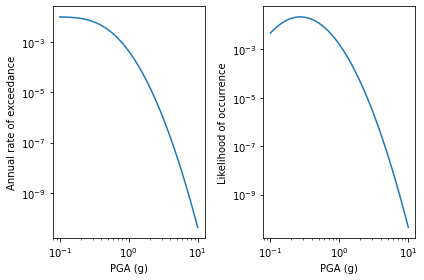

In [2]:
# hazard submodule include both the hazard curve and the likelihood
# we only need the likelihood, but both are imported for illustration
# purposes
from pyRiskTable.example.hazard import hazard_curve, hazard_likelihood

# we can plot the hazard likelihood using the code below:
im_array = np.geomspace(0.1, 10, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, tight_layout=True)
axes[0].loglog(im_array, hazard_curve(im_array), '-')
axes[1].loglog(im_array, hazard_likelihood(im_array), '-')
axes[0].set(xlabel='PGA (g)', ylabel='Annual rate of exceedance')
axes[1].set(xlabel='PGA (g)', ylabel='Likelihood of occurrence')
plt.show()

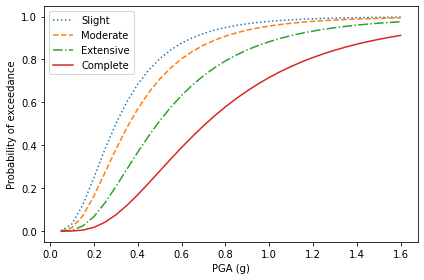

In [3]:
# fragility_curve returns function representing the fragility curves
from pyRiskTable.example.fragility import fragility_curve

fragility_s = fragility_curve(damage_state='slight')
fragility_m = fragility_curve(damage_state='moderate')
fragility_e = fragility_curve(damage_state='extensive')
fragility_c = fragility_curve(damage_state='complete')

# we can plot these curves using the code below:
im_array = np.arange(0.05, 1.65, 0.05)
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True)
ax.plot(im_array, fragility_s(im_array), ':')
ax.plot(im_array, fragility_m(im_array), '--')
ax.plot(im_array, fragility_e(im_array), '-.')
ax.plot(im_array, fragility_c(im_array), '-')
ax.set_xlabel('PGA (g)')
ax.set_ylabel('Probability of exceedance')
ax.legend(['Slight', 'Moderate', 'Extensive', 'Complete'])
plt.show()

In [4]:
# In the example, these consequences are expressed in terms damage ratios
from pyRiskTable.example.constants import CQ_S, CQ_M, CQ_E, CQ_C
cq_array = np.array([CQ_S, CQ_M, CQ_E, CQ_C])

**We will present how to use user defined hazard and fragility curves in the last section of this notebook**.

After preparing the functions and array, we are ready to

* Compute the expected consequence(s) given IM value(s)
* Compute the integrand of the risk integral, i.e., the conditional risk(s) given IM(s)

To do this, we use functions from the `risk` submodule

In [5]:
# We first compute the expected consequences given PGA=1g
from pyRiskTable.risk import expected_consequence

example_im = 1
consequence = expected_consequence(1,
    fragility_funcs=[fragility_s, fragility_m, fragility_e, fragility_c],
    cq_array=cq_array)
print(f'Expect damage consequence (in terms of damage ratio) at 1(g) PGA = {consequence}')

Expect damage consequence (in terms of damage ratio) at 1(g) PGA = 0.8125004465825274


In [6]:
# By combining the hazard likelihood with the expected consequences,
# we have the integrand of the risk integral
from pyRiskTable.risk import risk_integrand

example_im = 1
integrand = risk_integrand(1, hazard_func=hazard_likelihood,
    fragility_funcs=[fragility_s, fragility_m, fragility_e, fragility_c],
    cq_array=cq_array)
print(f'Risk integrand at IM = 1(g) PGA = {integrand}')

Risk integrand at IM = 1(g) PGA = 0.0013018329365043174


## Generate weighted hazard scenarios and estimate risk

Here we focus on individual probabilistic hazards, as described in Section 2.4.2. The risk integral can be expressed as

$$ R = \int_{im} \left[ \sum_{ds} cq(ds) \cdot p_{DS|IM}(ds|im) \cdot \lambda_{IM}(im) \right] \mathrm{d} im $$

Weighted hazard scenarios are generated to numerical evaluate this risk integral. Hence, before generating scenarios, we need to know the lower and upper limits first.

If we know these limits in terms of intensity measures, this is straightforward. Alternatively, for the example in the report, if we know the return periods associated with the limits, we can use the `inv_hazard_curve` function in the `example.hazard` submodule to back calculate the limits.

In [7]:
from pyRiskTable.example.hazard import inv_hazard_curve

period_lb, period_ub = 100.1, 1e5    # the lower and upper return periods
rate_lb, rate_ub = 1/period_ub, 1/period_lb    # annual rate of exceedance

# integration domain in terms of IM
im_lb = inv_hazard_curve(rate_ub)
im_ub = inv_hazard_curve(rate_lb)

The hazard scenarios and their corresponding weights can be generated using the `scenario` submodule.

In this process, the risk will be tabulated automatically as well.

In [8]:
from pyRiskTable.scenario import generate_primary_event

ims, scalers, likes, cqs, val, err = generate_primary_event(im_lb, im_ub,
    likelihood_func=hazard_likelihood, kw_likelihood={}, vec_likelihood=True,
    consequence_func=expected_consequence,
    kw_consequence={
        'fragility_funcs': [fragility_s, fragility_m, fragility_e, fragility_c],
        'cq_array': cq_array
    },
    vec_consequence=True,
    rtol=0.05, min_order=4, max_order=10)

print(f'The estimated risk = {val}')

The estimated risk = 0.0034000475779209604


> __Note__: In the example, we use 0.05 as the relative tolerance between the consecutive numbers of hazard scenarios before considering the integration is converged. Also, we set minimum number as 4 to avoid premature stopping. The maximum number of scnearios is set as 10.

We can also export the scenario events to a `csv` file and evaluate risk with this `csv` file using the `tools` submodule.

In [9]:
from pyRiskTable.tools import export_primary_scenarios, risk_from_primary_scenarios

filepath = "./tutorial1.csv"
export_primary_scenarios(ims, scalers, likes, cqs, hazard_curve=hazard_curve, vec_func=True, filepath=filepath)

# we can also compute risk from saved csv file
risk_ext = risk_from_primary_scenarios(filepath=filepath)

print(f'The estimated risk from external file = {risk_ext}')

# display the generated table
scenario_table = pd.read_csv(filepath, index_col=0)
display(scenario_table)

The estimated risk from external file = 0.0034000475779209244


,Likelihood,Intensity,Consequences,Weights,Return Period
0,0.010535,0.136218,0.021287,0.181835,103.898578
1,0.016134,0.424119,0.347650,0.382893,240.437520
2,0.002690,0.872634,0.751784,0.496619,1435.092373
3,0.000376,1.379150,0.916392,0.496619,8873.448855
4,0.000081,1.827664,0.965599,0.382893,36246.669129
5,0.000033,2.115565,0.979789,0.181835,82265.171608


## Use custom hazard and fragility functions

In the `tool` module, we offer the easy solution to using custom hazard likelihood function and fragility functions. These custom functions should be provided as pairs of input-output mappings, and we use interpolation to convert it to python function. Therefore, the provided mappings should cover the integral domain.

**Note: The hazard function should be the likelihood function not the hazard curve.**

Alternatively, one can create their own submodule similar to `example` to implement their own hazard and fragility functions.

In the following cell, we create the functions based on csv files generated with the functions in the `example` module.

In [10]:
# # uncomment the following block to generate the csv files
# from pyRiskTable.example.hazard import hazard_likelihood
# im_array = np.geomspace(0.01, 5, 100)
# hazard_df = pd.DataFrame({
#     'Intensity': im_array,
#     'Likelihood': hazard_likelihood(im_array)
# })
# hazard_df.to_csv('user_hazard.csv')

# from pyRiskTable.example.fragility import fragility_curve
# im_array = np.linspace(0.01, 5, 100)
# cdf_s = fragility_curve(damage_state='slight')(im_array)
# cdf_m = fragility_curve(damage_state='moderate')(im_array)
# cdf_e = fragility_curve(damage_state='extensive')(im_array)
# cdf_c = fragility_curve(damage_state='complete')(im_array)
# fragility_df = pd.DataFrame({
#     'IM': im_array,
#     'Slight': cdf_s,
#     'Moderate': cdf_m,
#     'Extensive': cdf_e,
#     'Complete': cdf_c
# })
# fragility_df.to_csv('./user_fragility.csv')

In [11]:
from pyRiskTable.tools import user_hazard_likelihood, user_fragility_curve

hazard_file = './user_hazard.csv'
hazard_likelihood_ext = user_hazard_likelihood(hazard_file, im_key='Intensity', like_key='Likelihood')

fragility_file = './user_fragility.csv'
fragility_s_ext = user_fragility_curve(fragility_file, im_key='IM', ds_key='Slight')
fragility_m_ext = user_fragility_curve(fragility_file, im_key='IM', ds_key='Moderate')
fragility_e_ext = user_fragility_curve(fragility_file, im_key='IM', ds_key='Extensive')
fragility_c_ext = user_fragility_curve(fragility_file, im_key='IM', ds_key='Complete')

> __Note__: We didn't provide similar function for cascading hazards since they require a 2D interpolation with grid data, which can be data intensive. In that case, it is recommended to create submodule with user defined functions following the `example` submodule.

## Python script to generate weighted scenarios and estimate risk

We combine the previous code snippets to a complete Python script.

In [12]:
import numpy as np

from pyRiskTable.example.hazard import hazard_likelihood, inv_hazard_curve, hazard_curve
from pyRiskTable.example.fragility import fragility_curve
from pyRiskTable.example.constants import CQ_S, CQ_M, CQ_E, CQ_C

from pyRiskTable.scenario import generate_primary_event
from pyRiskTable.risk import expected_consequence
from pyRiskTable.tools import export_primary_scenarios

fragility_s = fragility_curve(damage_state='slight')
fragility_m = fragility_curve(damage_state='moderate')
fragility_e = fragility_curve(damage_state='extensive')
fragility_c = fragility_curve(damage_state='complete')

cq_array = np.array([CQ_S, CQ_M, CQ_E, CQ_C])

# integration domain in terms of IM
period_lb, period_ub = 100.1, 1e5    # the lower and upper return periods
rate_lb, rate_ub = 1/period_ub, 1/period_lb    # annual rate of exceedance
im_lb = inv_hazard_curve(rate_ub)
im_ub = inv_hazard_curve(rate_lb)

# generate scenarios and estimate risk
ims, scalers, likes, cqs, val, err = generate_primary_event(im_lb, im_ub,
    likelihood_func=hazard_likelihood, kw_likelihood={}, vec_likelihood=True,
    consequence_func=expected_consequence,
    kw_consequence={
        'fragility_funcs': [fragility_s, fragility_m, fragility_e, fragility_c],
        'cq_array': cq_array
    },
    vec_consequence=True,
    rtol=0.05, min_order=4, max_order=10)

print(f'The estimated risk = {val}')

# export weighted scenarios for BMS use
filepath = "./tutorial1.csv"
export_primary_scenarios(ims, scalers, likes, cqs, hazard_curve=hazard_curve, vec_func=True, filepath=filepath)

The estimated risk = 0.0034000475779209604
